In [1]:
!pip install deepxde

In [2]:
import numpy as np
import deepxde as dde
import torch
import matplotlib.pyplot as plt

dde.backend.backend_name = "pytorch"

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



In [3]:
#Defining the domain
x_min = -5
x_max = 5
t_min = 0
t_max = np.pi/2

In [4]:
#Create spatial and temporal grids for plotting
x = np.linspace(x_min, x_max, 200)
t = np.linspace(t_min, t_max, 100)
X, T = np.meshgrid(x, t)
X_test = np.hstack((X.flatten()[:,None], T.flatten()[:, None]))

In [5]:
# Define the geometry and time domain for DeepXDE
geom = dde.geometry.Interval(x_min, x_max)
timedomain = dde.geometry.TimeDomain(t_min, t_max)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [6]:
# Define the PDE system
def pde(x, y):
  u = y[:, 0:1] # Real part
  v = y[:, 1:2] # Imaginary part

  # Derivatives
  u_t = dde.grad.jacobian(y, x, i=0, j=1)
  v_t = dde.grad.jacobian(y, x, i=1, j=1)
  u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
  v_xx = dde.grad.hessian(y, x, component=1, i=0,j=0)

  #Residuals
  f_u = u_t + 0.5 * v_xx + (u**2 + v**2) * v
  f_v = -v_t + 0.5 * u_xx + (u**2 + v**2) * u
  return [f_u, f_v]

In [7]:
# Define the initial conditions
def ic_u_value(x):
  return 2/np.cosh(x[:, 0:1])

def ic_v_value(x):
  return np.zeros_like(x[:, 0:1])

def on_initial(x, on_boundary):
  return on_boundary and np.isclose(x[1], t_min)

def on_boundary(x, on_boundary):
  return on_boundary

In [8]:
# Define the periodic boundary conditions
# PeriodicBC(geomtime, component_x, on_boundary, derivative_order=0, component=0)
bc_u = dde.icbc.PeriodicBC(geomtime, 0, on_boundary, derivative_order=0, component=0)
bc_u_x = dde.icbc.PeriodicBC(geomtime, 0, on_boundary, derivative_order=1, component=0)
bc_v = dde.icbc.PeriodicBC(geomtime, 0, on_boundary, derivative_order=0, component=1)
bc_v_x = dde.icbc.PeriodicBC(geomtime, 0, on_boundary, derivative_order=1, component=1)

In [9]:
#Initial Conditions
ic_u = dde.icbc.IC(geomtime, ic_u_value, on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, ic_v_value, on_initial, component=1)

In [10]:
#Combine the PDE, initial conditions and boundary conditions
data = dde.data.TimePDE(geomtime, pde, [ic_u, ic_v, bc_u, bc_u_x, bc_v, bc_v_x], num_domain=5000, num_boundary=200, num_initial=200)

# Neural Network Configuration and Training

In [11]:
# Neural Network
layer_size = [2] + [100] * 8 + [2]
activation = 'tanh'
initializer = 'Glorot uniform'
net = dde.nn.FNN(layer_size, activation, initializer)

# The Model
model = dde.Model(data, net)

# Model optimization
model.compile("adam", lr=0.001)
model.train(iterations=40000)

Compiling model...
Building feed-forward neural network...
'build' took 0.133337 s

'compile' took 2.922246 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [1.76e-01, 7.02e-01, 1.46e+00, 1.62e-01, 3.99e+00, 7.00e-05, 9.15e-01, 9.16e-04]    [1.76e-01, 7.02e-01, 1.46e+00, 1.62e-01, 3.99e+00, 7.00e-05, 9.15e-01, 9.16e-04]    []  
1000      [8.84e-03, 8.37e-03, 1.58e-02, 1.70e-03, 2.46e-05, 1.93e-04, 9.83e-04, 2.37e-05]    [8.84e-03, 8.37e-03, 1.58e-02, 1.70e-03, 2.46e-05, 1.93e-04, 9.83e-04, 2.37e-05]    []  
2000      [7.13e-03, 4.89e-03, 9.08e-03, 3.55e-04, 2.02e-05, 2.04e-05, 2.28e-05, 2.27e-05]    [7.13e-03, 4.89e-03, 9.08e-03, 3.55e-04, 2.02e-05, 2.04e-05, 2.28e-05, 2.27e-05]    []  
3000      [3.18e-03, 2.97e-03, 4.86e-03, 6.50e-05, 1.04e-05, 2.50e-06, 1.99e-06, 4.20e-05]    [3.18e-03, 2.97e-03, 4.86e-03, 6.50e-

(<deepxde.model.LossHistory at 0x7cd25f135f50>,
 <deepxde.model.TrainState at 0x7cd25f3c3e50>)

# Fine Tuning the model using 'L-BFGS' optimizer

In [12]:
# Refining the solution using L-BFGS optimizer
model.compile('L-BFGS')
model.train()

Compiling model...
'compile' took 0.821437 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
40000     [2.15e-04, 6.62e-04, 4.90e-05, 8.93e-06, 1.92e-05, 1.65e-06, 7.32e-05, 1.35e-07]    [2.15e-04, 6.62e-04, 4.90e-05, 8.93e-06, 1.92e-05, 1.65e-06, 7.32e-05, 1.35e-07]    []  
40021     [2.15e-04, 6.62e-04, 4.90e-05, 8.93e-06, 1.92e-05, 1.65e-06, 7.32e-05, 1.35e-07]    [2.15e-04, 6.62e-04, 4.90e-05, 8.93e-06, 1.92e-05, 1.65e-06, 7.32e-05, 1.35e-07]    []  

Best model at step 28000:
  train loss: 2.75e-04
  test loss: 2.75e-04
  test metric: []

'train' took 4.715485 s



(<deepxde.model.LossHistory at 0x7cd25f135f50>,
 <deepxde.model.TrainState at 0x7cd25f3c3e50>)

# Visualizations

In [13]:
#Predict the solution
prediction = model.predict(X_test)
u_pred = prediction[:, 0].reshape(100, 200)
v_pred = prediction[:, 1].reshape(100, 200)
h_pred = np.sqrt(u_pred**2 + v_pred**2)

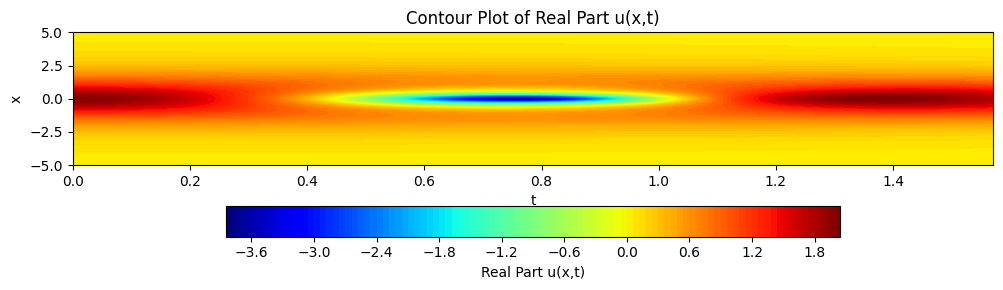

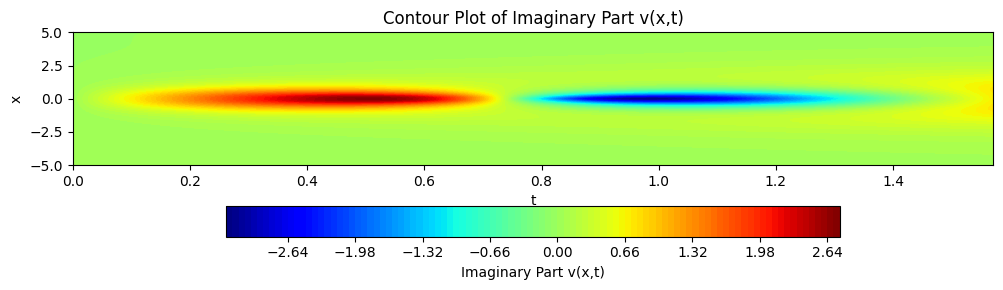

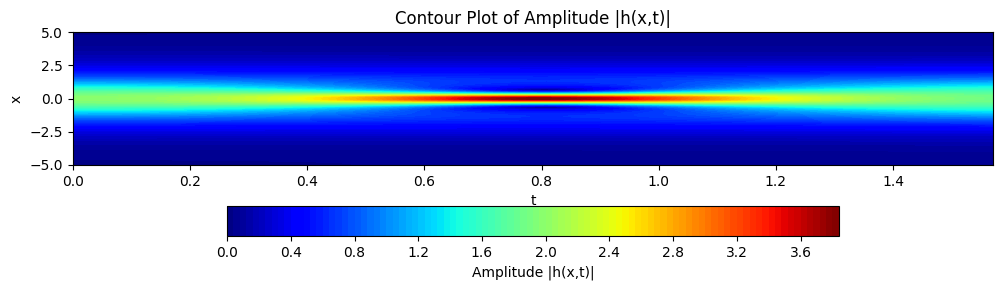

In [14]:
t_length = 10
x_length = 3

#Plot u(x,t) - Real Part
plt.figure(figsize=(t_length, x_length))
contour = plt.contourf(T, X, u_pred, 100, cmap='jet')
cbar = plt.colorbar(contour, orientation = 'horizontal', pad=0.2)
cbar.set_label("Real Part u(x,t)")
plt.title("Contour Plot of Real Part u(x,t)")

plt.xlabel("t")
plt.ylabel("x")
plt.xlim(0, np.pi/2)
plt.ylim(-5, 5)
plt.tight_layout()
plt.show()

#Plot u(x,t) - Real Part
plt.figure(figsize=(t_length, x_length))
contour = plt.contourf(T, X, v_pred, 100, cmap='jet')
cbar = plt.colorbar(contour, orientation = 'horizontal', pad=0.2)
cbar.set_label("Imaginary Part v(x,t)")
plt.title("Contour Plot of Imaginary Part v(x,t)")

plt.xlabel("t")
plt.ylabel("x")
plt.xlim(0, np.pi/2)
plt.ylim(-5, 5)
plt.tight_layout()
plt.show()

# Plot |h(x,t)| - Amplitude
plt.figure(figsize=(t_length, x_length))
contour = plt.contourf(T, X, h_pred, 100, cmap='jet')
cbar = plt.colorbar(contour, orientation = 'horizontal', pad=0.2)
cbar.set_label("Amplitude |h(x,t)|")
plt.title("Contour Plot of Amplitude |h(x,t)|")

plt.xlabel("t")
plt.ylabel("x")
plt.xlim(0, np.pi/2)
plt.ylim(-5, 5)
plt.tight_layout()
plt.show()

# Validation

In [15]:
#Physics Informed Residuals

y_symbolic = model.predict(X_test, operator=pde)
f_u = y_symbolic[0].reshape(100, 200)
f_v = y_symbolic[1].reshape(100, 200)

# Residual statistics
f_u_mean = np.mean(np.abs(f_u))
f_u_max  = np.max(np.abs(f_u))
f_v_mean = np.mean(np.abs(f_v))
f_v_max = np.max(np.abs(f_v))

print(f"Residuals (u): MEan = {f_u_mean:.4e}, Max = {f_u_max:.4e}")
print(f"Residuals (v): MEan = {f_v_mean:.4e}, Max = {f_v_max:.2e}")


Residuals (u): MEan = 8.8332e-03, Max = 1.1804e+00
Residuals (v): MEan = 1.0610e-02, Max = 8.36e-01


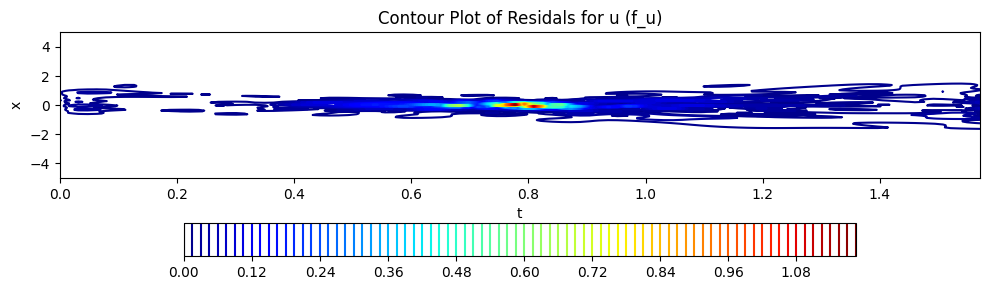

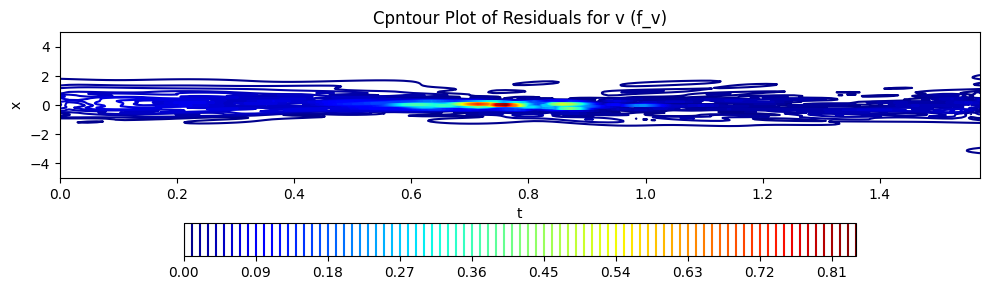

In [16]:
#Plot residuals for u
plt.figure(figsize=(t_length, x_length))
plt.contour(T, X, np.abs(f_u), 100, cmap='jet')
plt.colorbar(orientation = 'horizontal', pad=0.2)
plt.title("Contour Plot of Residals for u (f_u)")

#Set axis labels and limits
plt.xlabel("t")
plt.ylabel("x")
plt.xlim(0, np.pi/2)
plt.ylim(-5, 5)
plt.tight_layout()
plt.show()

#Plot residuals for v
plt.figure(figsize=(t_length, x_length))
plt.contour(T, X, np.abs(f_v), 100, cmap='jet')
plt.colorbar(orientation = 'horizontal', pad = 0.2)
plt.title("Cpntour Plot of Residuals for v (f_v)")

#Set axis labels and limits
plt.xlabel("t")
plt.ylabel("x")
plt.xlim(0, np.pi/2)
plt.ylim(-5, 5)
plt.tight_layout()
plt.show()

# Boundary Condition Verification

In [17]:
#Boundary Condition Verification
u_xm5 = u_pred[:, 0] #u at x = -5 for all t
u_xp5 = u_pred[:, -1] #u at x = 5 for all t
v_xm5 = v_pred[:, 0] #v at x = -5 for all t
v_xp5 = v_pred[:, -1] #v at x = 5 for all t

bc_error_u = np.mean(np.abs(u_xm5 - u_xp5))
bc_error_v = np.mean(np.abs(v_xm5 - v_xp5))

print(f"Boundary Condition Error (u): {bc_error_u:.4e}")
print(f"Boundary Condition Error (v): {bc_error_v:.4e}")

Boundary Condition Error (u): 4.3636e-03
Boundary Condition Error (v): 8.5497e-03


# Initial Condition Verification

In [18]:
# Create evaluation points for validation
X_flat = X.flatten()
T_flat = T.flatten()

# Initial condition verification
t0_indices = np.isclose(T_flat, 0)
u_t0 = u_pred[0, :] #First time slice (t=0)
v_t0 = v_pred[0, :] #First time slice (t=0)
u_true_t0 = 2/np.cosh(X_flat[t0_indices])

init_error_u = np.mean(np.abs(u_t0 - u_true_t0))
init_error_v = np.mean(np.abs(v_t0))

print(f"Initial Condition Error (u): {init_error_u:.4e}")
print(f"Initial Condition Error (v): {init_error_v:.4e}")


Initial Condition Error (u): 5.7652e-03
Initial Condition Error (v): 2.6178e-03


# Energy Conservation Analysis

Max energy change: 3.2965e-01


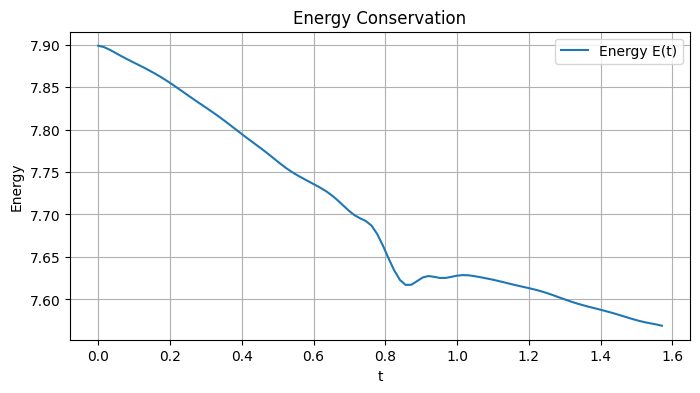

In [19]:
# Energy Conservation
dx = (x_max - x_min) / (len(x) - 1)
E_t = np.sum(u_pred**2 + v_pred**2, axis=1) * dx

#Calculate maximum energy deviation
E_initial = E_t[0]
E_change = np.abs(E_t - E_initial)
max_E_change = np.max(E_change)

print(f"Max energy change: {max_E_change:.4e}")

# Plot energy conservation
plt.figure(figsize=(8,4))
plt.plot(t, E_t, label = "Energy E(t)")
plt.xlabel("t")
plt.ylabel("Energy")
plt.title("Energy Conservation")
plt.legend()
plt.grid()
plt.show()